<h2 style="font-weigt:bold;">TUGAS BESAR A MACHINE LEARNING</h2>

- Arjuna Marcelino - 13519021
- Sharon Bernadetha Marbun - 13519092
- Epata Tuah - 13519120
- Giant Andreas Tambunan - 13519127

### Pembacaan Data

In [183]:
import pandas as pd

def read_model():
    f = pd.read_csv("model.csv")
    return f

def read_data():
    df = pd.read_csv('iris.csv')
    # encode species
    df['species'] = df['species'].replace(['setosa'],1)
    df['species'] = df['species'].replace(['versicolor'],2)
    df['species'] = df['species'].replace(['virginica'],3)

    # deviding species colloumn into 3 collumn
    y = pd.get_dummies(df.species, prefix='Class')
    df["Class_1"] = y["Class_1"]
    df["Class_2"] = y["Class_2"]
    df["Class_3"] = y["Class_3"]
    return df

### Fungsi Aktivasi

In [184]:
import math
import numpy as np

def linear(x, kwargs=None):
    return x
    
def sigmoid(x):
    value = float(1 / (1 + math.exp(x * -1)))
    return value

def relu(x, kwargs):
    alpha = kwargs.get("alpha", 0.0)
    max_value = kwargs.get("max_value", None)
    threshold = 0
    if x < threshold:
        return max(x, x * alpha)
    else:
        if max_value == None:
            return x
        else:
            return min(x, max_value)

### Kelas Neuron

In [185]:
class Neuron:
    def __init__(self, value, weight):
        self.value = value
        self.weight = weight    

    def set_value(self, value):
        self.value = value

    def set_weight(self, weight):
        self.weight = weight

    def get_result(self, prev_layer, activation):
        sigma = self.get_sigma(prev_layer=prev_layer)
        result = None
        if activation == "sigmoid":
            result = sigmoid(sigma)

        elif activation == "linier":
            result = linear(sigma)
            
        elif activation == "relu":
            result = relu(sigma)
        
        self.set_value(result)
    
    def get_sigma(self, prev_layer):
        i = 0
        sigma = 0
        for n in prev_layer.neurons:
            sigma += n.value * self.weight[i]
            i += 1
        sigma += prev_layer.bias.value
        
        return sigma

    def get_string_json(self):
        string = "\t\t\t{\n"
        string += f'\t\t\t\t"value" : {self.value},\n'
        w = self.weight
        if self.weight != None:
            w = self.weight 
        else:
            w = "null"
        string += f'\t\t\t\t"weight" : {w}\n'
        string += "\t\t\t}"
        return string

### Kelas Layer

In [186]:
import random

class Layer:
    def __init__(self, idx:int, num_of_neuron:int, activation:str, type:str, prev_layer):
        self.bias = Neuron(random.random(), weight=None)
        self.neurons = []
        self.activation = activation
        self.idx = idx
        self.type = type
        self.prev_layer = prev_layer

        if type == "input":
            for i in range(num_of_neuron):
                n = Neuron(0, weight=None)
                self.neurons.append(n)

        elif type == "hidden":
            num_prev_neuron = len(prev_layer.neurons)
            for i in range(num_of_neuron):
                n = Neuron(0, weight=[random.random() for x in range(num_prev_neuron)])
                self.neurons.append(n)

        elif type == "output":
            self.bias = None
            num_prev_neuron = len(prev_layer.neurons)
            for i in range(num_of_neuron):
                n = Neuron(0, weight=[random.random() for x in range(num_prev_neuron)])
                self.neurons.append(n)


    def set_values(self, values):
        i = 0
        for n in self.neurons:
            n.set_value(values[i])
            i += 1

    def set_neuron_bias(self, biases):
        i = 0
        for n in self.neurons:
            n.bias_weight = biases[i]
            i += 1

    def set_weights(self, weights:list[list[float]]):
        i = 0
        for n in self.neurons:
            n.set_weight(weights[i])
            i += 1

    def get_result(self):
        for n in self.neurons:
            n.get_result(self.prev_layer, self.activation)

    def back_prop(self, detot, learning_rate):
        # check if not input layer
        if self.type == "input":
            return
        
        i = 0
        temp_detot = []
        for n in self.neurons:
            derr_tot = 0
            dout_dnet = n.value * (1 - n.value)
            for err in detot:
                derr_tot += err[i]
            temp = derr_tot * dout_dnet
            temp_neuron = []

            for j in range(len(n.weight)):
                dnet_dw = self.prev_layer.neurons[j].value
                derr_dw = derr_tot * dout_dnet * dnet_dw
                temp_neuron.append(temp * n.weight[j])
                # update weight
                updated = n.weight[j] - (learning_rate * derr_dw)
                n.weight[j] = updated

            temp_detot.append(temp_neuron)
            i += 1
        
        self.prev_layer.back_prop(temp_detot, learning_rate)

    def print_layer(self):
        print(f"Layer {self.idx} ({self.type})")
        print(f"activation func = {self.activation}")
        for n in self.neurons:
            print(f"Neuron weight = {n.weight} \t Neuron value = {n.value}")
        if self.type != "output":
            print(f"Bias = {self.bias.value}")
        print(f"prev layer idx = {self.prev_layer}")
        print("\n")

    def get_string_json(self):
        # attribute
        string = "\t\t{\n"
        string += f'\t\t\t"idx": "{self.idx}",\n'
        string += f'\t\t\t"num_of_neuron": "{len(self.neurons)}",\n'
        string += f'\t\t\t"activation": "{self.activation}",\n'
        string += f'\t\t\t"type": "{self.type}",\n'
        # neuron
        string += f'\t\t\t"neurons": [\n'
        i = 0
        for neu in self.neurons:
            string += neu.get_string_json()
            if i != len(self.neurons)-1:
                string += ','
            i += 1
        string += '],\n'
        bias = self.bias
        if bias == None:
            bias = "null"
        else:
            bias = bias.value
        string += f'\t\t\t"bias": {bias}'
        string += "\t\t}"
        return string

### Kelas FFNN

In [187]:
# FFNN Class
import json
from collections import namedtuple

# customDecoder function for read from json
def customDecoder(dict):
    return namedtuple('X', dict.keys())(*dict.values())

class FeedForwardNeuralNetwork:
    def __init__(self, model, learning_rate, error_threshold, max_iteration, json_filename):
        if json_filename != None:
            # read json file
            file = open(json_filename, 'r')
            ffnn_json = json.load(file, object_hook = customDecoder)

            self.input_layer = Layer(ffnn_json.input_layer.idx,
                                        int(ffnn_json.input_layer.num_of_neuron),
                                        ffnn_json.input_layer.activation,
                                        ffnn_json.input_layer.type,
                                        prev_layer=None)

            self.input_layer.bias.value = float(ffnn_json.input_layer.bias)
            i = 0
            # update weight
            for neu in self.input_layer.neurons:
                neu.value = ffnn_json.input_layer.neurons[i].value
                neu.weight = ffnn_json.input_layer.neurons[i].weight
                i += 1
            
            
            self.hidden_layer = []
            i = 0
            temp = self.input_layer
            for hid in ffnn_json.hidden_layer:
                hid = Layer(ffnn_json.hidden_layer[i].idx,
                            int(ffnn_json.hidden_layer[i].num_of_neuron),
                            ffnn_json.hidden_layer[i].activation,
                            ffnn_json.hidden_layer[i].type,
                            prev_layer= temp)
                j = 0
                # update weight
                for neu in hid.neurons:
                    neu.value = float(ffnn_json.hidden_layer[i].neurons[j].value)
                    neu.weight = ffnn_json.hidden_layer[i].neurons[j].weight
                    j += 1
                
                hid.bias.value = float(ffnn_json.hidden_layer[i].bias)
                self.hidden_layer.append(hid)
                temp = hid
                i += 1

            self.output_layer = Layer(ffnn_json.output_layer.idx,
                                        int(ffnn_json.output_layer.num_of_neuron),
                                        ffnn_json.output_layer.activation,
                                        ffnn_json.output_layer.type,
                                        prev_layer=temp)
            # update weight
            i = 0
            for neu in self.output_layer.neurons:
                neu.value = float(ffnn_json.output_layer.neurons[i].value)
                neu.weight = ffnn_json.output_layer.neurons[i].weight
                i += 1
            
            self.output_layer.bias = ffnn_json.output_layer.bias
            self.learning_rate = float(ffnn_json.learning_rate)
            self.error_threshold = float(ffnn_json.error_threshold)
            self.max_itteration = int(ffnn_json.max_iteration)
            return
        
        self.input_layer = None
        self.hidden_layer = []
        self.output_layer = None
        self.learning_rate = learning_rate
        self.error_threshold = error_threshold
        self.max_itteration = max_iteration

        temp_layer = None
        for index, items in model.iterrows():
            if index == 0:
                self.input_layer = Layer(index, items["neuron"], items["activation"], "input", prev_layer=None)
                temp_layer = self.input_layer
            elif index > 0 and index < model.index.stop - 1:
                layer = Layer(index, items["neuron"], items["activation"], "hidden", prev_layer=temp_layer)
                temp_layer = layer
                self.hidden_layer.append(layer)
            elif index == model.index.stop-1:
                self.output_layer = Layer(index, items["neuron"], items["activation"], "output", prev_layer=temp_layer)

    def forward_propagation(self, input):
        # assume len input = len input_layer.neurons
        self.input_layer.set_values(input)
        for lay in self.hidden_layer:
            lay.get_result()
        self.output_layer.get_result()
        
    def backward_propagation(self, target):
        i = 0
        temp_detot = []
        # update output layer weights
        for out_n in self.output_layer.neurons:
            derr_dout = out_n.value - target[i]
            dout_dy = out_n.value * (1- out_n.value)
            temp = derr_dout * dout_dy
            temp_neuron = []
            
            for j in range(len(out_n.weight)):
                dy_dw = self.output_layer.prev_layer.neurons[j].value
                derr_dw = derr_dout * dout_dy * dy_dw
                temp_neuron.append(temp * out_n.weight[j]) # for hidden layer
                # update
                updated = out_n.weight[j] - (self.learning_rate * derr_dw)
                out_n.weight[j] = updated
            
            temp_detot.append(temp_neuron)
            i += 1
        
        # backprop and update for hidden layer
        self.output_layer.prev_layer.back_prop(temp_detot, self.learning_rate)
        
    
    def learn(self, data_train):
        # fromat data_train harus sesuai dengan data yang diambil dari read_data()  
        # iterate for each data
        for idx, data in data_train.iterrows():
            input = []
            # input
            for i in range(len(self.input_layer.neurons)):
                input.append(data[i])
            
            # output
            target = [data["Class_1"], data["Class_2"], data["Class_3"]]

            # set input layer
            self.input_layer.set_values(input)
            # forward and backward propagation
            self.forward_propagation(input)
            self.backward_propagation(target)
            # print(f"COST = {self.get_error_cost(target)}")
        

    def get_error_cost(self, target):
        cost = 0
        i = 0
        for n in self.output_layer.neurons:
            dif = target[i] - n.value
            cost += (dif ** 2)/2
            i += 1
        return cost

    def predict(self, test_data):
        result = []
        num_true = 0
        for idx, data in test_data.iterrows():
            input = []
            # input
            for i in range(len(self.input_layer.neurons)):
                input.append(data[i])
            # output
            target = [data["Class_1"], data["Class_2"], data["Class_3"]]

            # set input layer
            self.input_layer.set_values(input)
            # forward propagation
            self.forward_propagation(input)
            temp = -1
            idx = 0
            i = 1
            for out_n in self.output_layer.neurons:
                if temp < out_n.value:
                    temp = out_n.value
                    idx = i
                i += 1
            temp_result = []
            if idx == 1:
                temp_result = [1, 0, 0]
            elif idx == 2:
                temp_result = [0, 1, 0]
            elif idx == 3:
                temp_result = [0, 0, 1]
            
            result.append(temp_result)
            # predict
            if target == temp_result:
                num_true += 1
            # print(f'target = {target}')
            # print(f'pred = {temp_result}')
        return result, num_true/len(result)

    def print_neural_network(self):
        self.input_layer.print_layer()
        for lay in self.hidden_layer:
            lay.print_layer()
        self.output_layer.print_layer()

    def get_str_json(self):
        # __init__(self, model, learning_rate, error_threshold, max_iteration):
        string = "{\n"
        string += f'\t"learning_rate": "{self.learning_rate}",\n'
        string += f'\t"error_threshold": "{self.error_threshold}",\n'
        string += f'\t"max_iteration": "{self.max_itteration}",\n'
        string += f'\t"input_layer": {self.input_layer.get_string_json()},\n'
        string += f'\t"hidden_layer": [\n'
        for lay in self.hidden_layer:
            string += lay.get_string_json()
        string += '],\n'
        string += f'\t"output_layer": {self.output_layer.get_string_json()}\n'
        string += "}"
        return string

    def save_to_json(self, file_name):
        jsonFile = open(file_name, "w")
        jsonFile.write(self.get_str_json())
        jsonFile.close()


### Utilitas

In [188]:
def convert_result(result):
    new = []
    for i in range(len(result)):
        if result[i] == [1, 0, 0]:
            new.append(0)
        elif result[i] == [0, 1, 0]:
            new.append(1)
        else:  # result[i] == [0,0,1]
            new.append(2)
    return new

def confusion_matrix(actual, predicted):
    actual0_predicted0 = 0
    actual0_predicted1 = 0
    actual0_predicted2 = 0
    actual1_predicted0 = 0
    actual1_predicted1 = 0
    actual1_predicted2 = 0
    actual2_predicted0 = 0
    actual2_predicted1 = 0
    actual2_predicted2 = 0
    num_data = len(actual)
    for i in range(num_data):
        if actual[i] == 0 and predicted[i] == 0:
            actual0_predicted0 += 1
        elif actual[i] == 0 and predicted[i] == 1:
            actual0_predicted1 += 1
        elif actual[i] == 0 and predicted[i] == 2:
            actual0_predicted2 += 1
        elif actual[i] == 1 and predicted[i] == 0:
            actual1_predicted0 += 1
        elif actual[i] == 1 and predicted[i] == 1:
            actual1_predicted1 += 1
        elif actual[i] == 1 and predicted[i] == 2:
            actual1_predicted2 += 1
        elif actual[i] == 2 and predicted[i] == 0:
            actual2_predicted0 += 1
        elif actual[i] == 2 and predicted[i] == 1:
            actual2_predicted1 += 1
        else:  # actual[i] == 2 and predicted[i] == 2:
            actual2_predicted2 += 1
    row0 = [actual0_predicted0, actual0_predicted1, actual0_predicted2]
    row1 = [actual1_predicted0, actual1_predicted1, actual1_predicted2]
    row2 = [actual2_predicted0, actual2_predicted1, actual2_predicted2]
    return [row0, row1, row2]

def performance_measure(conf_matrix):
    tp_se = conf_matrix[0][0]
    fn_se = conf_matrix[0][1] + conf_matrix[0][2]
    fp_se = conf_matrix[1][0] + conf_matrix[2][0]
    tn_se = conf_matrix[1][1] + conf_matrix[1][2] + conf_matrix[2][1] + conf_matrix[2][2]

    tp_ve = conf_matrix[1][1]
    fn_ve = conf_matrix[1][0] + conf_matrix[1][2]
    fp_ve = conf_matrix[0][1] + conf_matrix[2][1]
    tn_ve = conf_matrix[0][0] + conf_matrix[0][2] + conf_matrix[2][0] + conf_matrix[2][1]

    tp_vi = conf_matrix[2][2]
    fn_vi = conf_matrix[2][0] + conf_matrix[2][1]
    fp_vi = conf_matrix[0][2] + conf_matrix[1][2]
    tn_vi = conf_matrix[0][0] + conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[1][1]

    pos_se = tp_se+fn_se
    neg_se = fp_se+tn_se

    pos_aks_se = tp_se+fp_se

    pos_ve = tp_ve+fn_ve
    neg_ve = fp_ve+tn_ve

    pos_aks_ve = tp_ve+fp_ve

    pos_vi = tp_vi+fn_vi
    neg_vi = fp_vi+tn_vi

    pos_aks_vi = tp_vi+fp_vi

    Num = pos_se+neg_se

    akurasi = [(tp_se+tn_se)/Num, (tp_ve+tn_ve)/Num, (tp_vi+tn_vi)/Num ]
    presisi = [tp_se/pos_aks_se,tp_ve/pos_aks_ve,tp_vi/pos_aks_vi]
    recall = [tp_se/pos_se if pos_se != 0 else 0,tp_ve/pos_ve if pos_ve != 0 else 0,tp_vi/pos_vi if pos_vi != 0 else 0]
    f1 = [2*(presisi[0]*recall[0])/(presisi[0]+recall[0]) if presisi[0]+recall[0] != 0 else 0,2*(presisi[1]*recall[1])/(presisi[1]+recall[1]) if presisi[1]+recall[1] != 0 else 0,2*(presisi[2]*recall[2])/(presisi[2]+recall[2])if presisi[2]+recall[2] != 0 else 0]

    return akurasi, presisi, recall, f1

### Eksekusi 

#### Pembelajaran dengan FFNN

In [189]:
model = read_model()
neural_network = FeedForwardNeuralNetwork(model=model, learning_rate=0.2, error_threshold=0.01, max_iteration=1000, json_filename=None)

data = read_data()

for i in range(1000):
    neural_network.learn(data)

result, acc = neural_network.predict(test_data=data)
predicted = convert_result(result)
print(f"predicted = {predicted}")

target = []
for idx, ins in data.iterrows():
    target.append([ins["Class_1"], ins["Class_2"], ins["Class_3"]])
    
actual = convert_result(target)
print(f"actual = {actual}")

print(f"Score = {acc}")


predicted = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
actual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Score = 0.9666666666666667


In [190]:
# Save Learned Model to file
neural_network.save_to_json("weighted_model.json")

# Test Creating Model from Weighted Saved Model
# read json file
test_neural_net = FeedForwardNeuralNetwork(model=None, learning_rate=None, error_threshold=None, max_iteration=None ,json_filename="weighted_model.json")
print("##### NEURAL NETWORK #####")
neural_network.print_neural_network()
print()
print("##### TEST NEURAL NETWORK #####")
test_neural_net.print_neural_network()

# test predict
t_result, t_acc = test_neural_net.predict(test_data=data)

test_predicted = convert_result(t_result)
print(f"test predicted = {test_predicted}")

print(f"actual = {actual}")

print(f"Test Score = {t_acc}")

##### NEURAL NETWORK #####
Layer 0 (input)
activation func = sigmoid
Neuron weight = None 	 Neuron value = 5.9
Neuron weight = None 	 Neuron value = 3.0
Neuron weight = None 	 Neuron value = 5.1
Neuron weight = None 	 Neuron value = 1.8
Bias = 0.07932107607648153
prev layer idx = None


Layer 1 (hidden)
activation func = sigmoid
Neuron weight = [0.9131528907147006, 0.66325248149847, 0.9542187823795043, 0.7714821331478509] 	 Neuron value = 0.9999988907931137
Neuron weight = [11.532232061017687, 14.727840809379005, -16.329590264102563, -22.70785436503329] 	 Neuron value = 7.123989518871428e-06
Neuron weight = [-0.5943564065194701, -2.613579792042957, 3.5995409506397174, 1.9691608823520357] 	 Neuron value = 0.999975918133309
Bias = 0.34982718450231376
prev layer idx = <__main__.Layer object at 0x0000016CFB711990>


Layer 2 (output)
activation func = sigmoid
Neuron weight = [-2.286685348083359, 6.398670789677466, -8.939332819569357] 	 Neuron value = 1.8907601998241967e-05
Neuron weight = [

<b> Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1 </b>

[[50, 0, 0], [0, 45, 5], [0, 0, 50]]


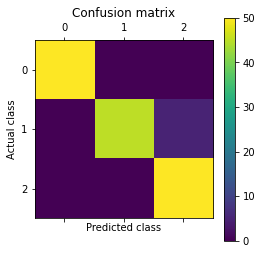

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  0.6333333333333333
Presisi = 1.0
Recall = 0.9
F1 =  0.9473684210526316

Kelas Virginica
Akurasi =  0.9666666666666667
Presisi = 0.9090909090909091
Recall = 1.0
F1 =  0.9523809523809523


In [191]:
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(actual, predicted)
print(conf_mat)
plt.matshow(conf_mat)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

pm = performance_measure(conf_mat)

print("Kelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])

#### Pembelajaran dengan SKlearn

In [192]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

iris = load_iris()
X = iris.data
y = iris.target

mlpclassifier = MLPClassifier(  hidden_layer_sizes=1,
                                learning_rate="constant",
                                activation="logistic",
                                solver="sgd",
                                batch_size=2,
                                learning_rate_init=0.1,
                                tol=0.1,
                                max_iter=200)

mlpclassifier.fit(X, y)

pred = mlpclassifier.predict(X)
print(f"predicted = {pred}")

print(f"actual = {y}")

print(f'Score = {accuracy_score(pred, y)}')

predicted = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
actual = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Score = 0.6666666666666666


#### Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1

Confusion matrix: [[50, 0, 0], [0, 50, 50], [0, 0, 0]]

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  0.6666666666666666
Presisi = 1.0
Recall = 0.5
F1 =  0.6666666666666666

Kelas Virginica
Akurasi =  0.6666666666666666
Presisi = 0.0
Recall = 0
F1 =  0


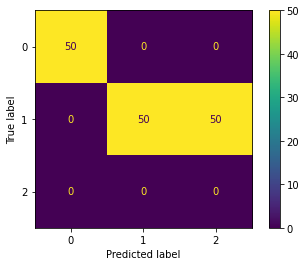

In [193]:
import numpy as np
cm = confusion_matrix(pred, y)

cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
print(f"Confusion matrix: {cm.tolist()}")
pm = performance_measure(cm.tolist())

print("\nKelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])


#### Pembelajaran dengan skema 90% training dan 10% test

In [194]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

train = data.sample(frac=0.9)
test = data.loc[~data.index.isin(train.index)]

for i in range(1000):
    neural_network.learn(train)
    
result, acc = neural_network.predict(test_data=test)
predicted = convert_result(result)
print(f"predicted = {predicted}")

target = []
for idx, ins in test.iterrows():
    target.append([ins["Class_1"], ins["Class_2"], ins["Class_3"]])
    
actual = convert_result(target)
print(f"actual = {actual}")

print(f"acc = {acc}")

predicted = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
actual = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
acc = 1.0


#### Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1

[[5 0 0]
 [0 5 0]
 [0 0 5]]


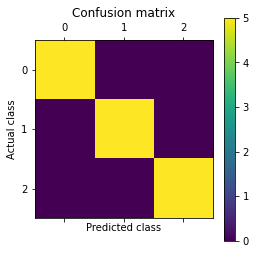

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  0.6666666666666666
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Virginica
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0


In [195]:
conf_mat = confusion_matrix(actual, predicted)
print(conf_mat)
plt.matshow(conf_mat)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

pm = performance_measure(conf_mat)

print("Kelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])

#### Pembelajaran dengan skema 10-fold cross validation

In [196]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state=0)
result = next(kf.split(data), None)
train = data.iloc[result[0]]
test =  data.iloc[result[1]]

for i in range(1000):
    neural_network.learn(train)
    
result, acc = neural_network.predict(test_data=test)
predicted = convert_result(result)
print(f"predicted = {predicted}")

target = []
for idx, ins in test.iterrows():
    target.append([ins["Class_1"], ins["Class_2"], ins["Class_3"]])
    
actual = convert_result(target)
print(f"actual = {actual}")

print(f"acc = {acc}")

predicted = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
actual = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
acc = 1.0


#### Confusion Matrix dan Perhitungan Akurasi, Presisi, Recall, dan F1

[[3 0 0]
 [0 8 0]
 [0 0 4]]


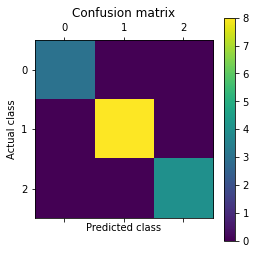

Kelas Setosa
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Versicolor
Akurasi =  0.7333333333333333
Presisi = 1.0
Recall = 1.0
F1 =  1.0

Kelas Virginica
Akurasi =  1.0
Presisi = 1.0
Recall = 1.0
F1 =  1.0


In [197]:
conf_mat = confusion_matrix(actual, predicted)
print(conf_mat)
plt.matshow(conf_mat)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

pm = performance_measure(conf_mat)

print("Kelas Setosa")
print("Akurasi = ",pm[0][0] )
print("Presisi =",pm[1][0])
print("Recall =",pm[2][0])
print("F1 = ",pm[3][0])
print("")
print("Kelas Versicolor")
print("Akurasi = ",pm[0][1] )
print("Presisi =",pm[1][1])
print("Recall =",pm[2][1])
print("F1 = ",pm[3][1])
print("")
print("Kelas Virginica")
print("Akurasi = ",pm[0][2] )
print("Presisi =",pm[1][2])
print("Recall =",pm[2][2])
print("F1 = ",pm[3][2])